# Baseline finder in CNN model

### problem description

For some events, simple program to find baseline can cause some bias like the event shown below:

In [1]:
from mtdScope import scopeEmulator
import matplotlib.pyplot as plt
import numpy as np
import time
#from scipy.optimize import curve_fit
import ROOT as rt
#from jupyterthemes import jtplot


#jtplot.style()
        
#load the sample data to test
se1 = scopeEmulator()
#se1.loadData('./data/SecondRun/Jan07_205749_Run9.hdf5')
se1.loadData('./data/Run1.hdf5')
se1.sliceEvent()
se1.load_cnn_baseline_finder('baseline_finder_v2.h5')

Welcome to JupyROOT 6.18/04
Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_24 (Conv1D)           (None, 498, 4)            28        
_________________________________________________________________
max_pooling1d_16 (MaxPooling (None, 249, 4)            0         
_________________________________________________________________
conv1d_25 (Conv1D)           (None, 49, 2)             50        
_________________________________________________________________
max_pooling1d_17 (MaxPooling (None, 24, 2)             0         
_________________________________________________________________
conv1d_26 (Conv1D)           (None, 9, 1)              17        
_________________________________________________________________
flatten_8 (Flatten)          (None, 9)                 0         
_________________________________________________________________
dense_16 (Dense)          

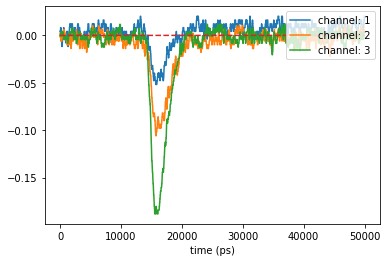

In [8]:
se1.showEvent(93,[1,2,3])

baseline: [[-0.17712274]]


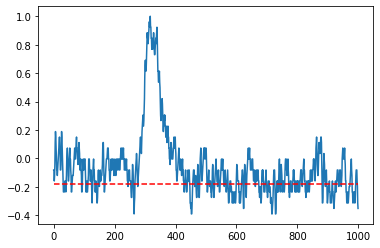

In [9]:
points = se1.getEventAdjusted(93)
bkg, data = se1.normalized_input(points[1])
base = se1.baseline_finder.predict(data.reshape(1,1000,1))
line = np.full(1000, base)
plt.plot(data)
plt.plot(line, '--',color='red')
print('baseline:',base)

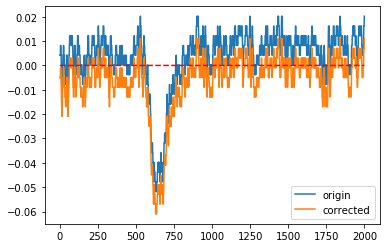

In [4]:
n=93
chan = 1
points = se1.getEventAdjusted(n)
points2 = se1.getEventAdjusted(n)
se1.cnn_baseline_correction(points,[1,2,3])
line = np.full(se1.nsamples,0)

plt.plot(points2[chan],label='origin')
plt.plot(points[chan],label='corrected')
plt.plot(line, '--',color='red')
plt.legend(loc='lower right')
plt.show()

In [5]:
charge1 = se1.charge_convertion(0,se1.nevent, 2, 0.04, [1],1)
charge0 = se1.charge_convertion(0,se1.nevent, 1, 0.02, [1,2],0)

In [6]:
charges1 = np.multiply(charge1[1],-1.0/44000)
charges0 = np.multiply(charge0[1],-1.0/44000)
plt.hist(charges1,bins=60,alpha=0.5)
plt.hist(charges0,bins=60,alpha=0.5)

NameError: name 'charge1' is not defined

In [ ]:

charges = np.multiply(charge1[1],-1.0/44000)
hchg = rt.TH1F("hchg0", "", 100, 0, .08)
for i in range(len(charges)):
    hchg.Fill(charges[i])
hchg.Scale(1.0/hchg.Integral())
canvas = rt.TCanvas("c", "", 500, 500)
flandau = rt.TF1("flandau", "[0]*TMath::Landau(x,[1],[2])", 0,0.08)
#bins = range(0, 0.08, 0.01)
#plt.plot(bin_edges[:-1], hist)
#plt.hist(charges, bins = 80)

#plt.xlabel("fC")


In [ ]:
flandau.SetParameters(0.1, 0.01, 0.01)

hchg.Draw()
hchg.Fit(flandau,"", "", 0,0.06)
canvas.Draw()

In [ ]:
h = np.array(charge0).transpose()
h